[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/examples/blob/main/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)

In [ ]:
from open_atmos_jupyter_utils import show_plot

In [1]:
import os
import sympy as sp
import numpy as np
import imageio
from IPython.display import display
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
from PyMPDATA import Solver, ScalarField, VectorField, Stepper, Options
from PyMPDATA.boundary_conditions import Periodic

In [2]:
mu = 0.05 # diffusion coefficient
dt = 0.025
tmax = 50.0
nt = int(tmax / dt)

nx = 32
ny = 32
ux  = 0.5
uy = 0.25

min_x, min_y = -1, -1
max_x, max_y = 1, 1
dx = (max_x - min_x) / nx
dy = (max_y - min_y) / ny
Cx = ux * dt / dx
Cy = uy * dt / dy

In [3]:
opt = Options(n_iters=3, non_zero_mu_coeff=True, infinite_gauge=True, nonoscillatory=True)
boundary_conditions = (Periodic(), Periodic())

In [4]:
solution_symbolic = sp.sympify("sin(pi*(x+y))*exp(-mu*pi**2*t) + 1", rational=True)
solution = solution_symbolic.subs({"mu": mu})

In [5]:
def init_conditions(x, y):
    return solution_symbolic.subs({"t":0, "x": x, "y": y}).evalf()

In [6]:
z = np.array(
    [
        init_conditions(x, y) for x in np.linspace(min_x, max_x, nx)
        for y in np.linspace(min_y, max_y, ny)
    ],
    dtype=float
).reshape((nx, ny))

advectee = ScalarField(data=z, halo=opt.n_halo, boundary_conditions=boundary_conditions)

In [7]:
field_x = np.full((nx+1, ny), Cx, dtype=opt.dtype)
field_y = np.full((nx, ny+1), Cy, dtype=opt.dtype)

advector = VectorField(
    data=(field_x, field_y),
    halo=opt.n_halo,
    boundary_conditions=(boundary_conditions[0], Periodic())
)

In [8]:
stepper = Stepper(options=opt, n_dims=2)
solver = Solver(stepper=stepper, advector=advector, advectee=advectee)

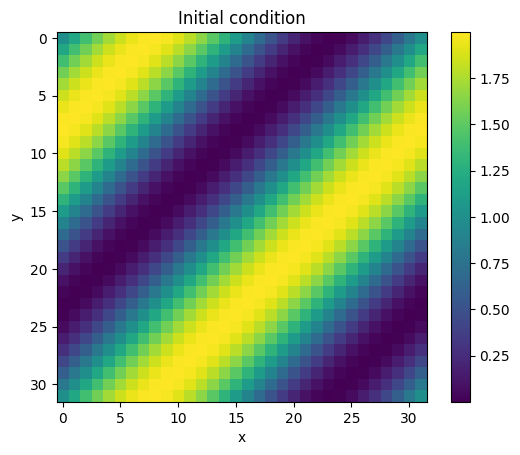

In [10]:
plt.imshow(solver.advectee.get().copy(), cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Initial condition')
plt.show()

In [11]:
progbar = FloatProgress(value=0, min=0, max=1)
display(progbar)

states_history = [solver.advectee.get().copy()]
for i in range(nt//10): # save every 10th step
    solver.advance(n_steps=10, mu_coeff=(mu, mu))
    states_history.append(solver.advectee.get().copy())
    progbar.value = (i + 1.) / (nt//10)

FloatProgress(value=0.0, max=1.0)

Text(0.5, 1.0, 'Final condition')

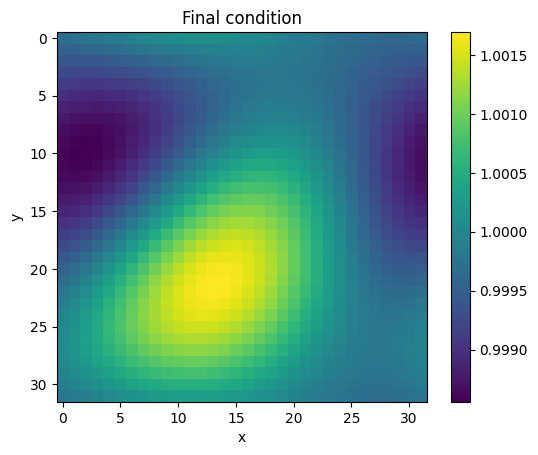

In [12]:
plt.imshow(solver.advectee.get().copy(), cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Final condition')

In [13]:
os.makedirs("animation", exist_ok=True)
for i, state in enumerate(states_history):
    state = np.flipud(state)
    plt.imshow(state, cmap='viridis')
    plt.axis('off')
    plt.tight_layout()
    plt.colorbar()
    plt.savefig(f"animation/frame_{i:03d}.png")
    plt.close()

In [14]:
def merge_images_into_gif(image_folder, gif_name, duration=0.01):
    with imageio.get_writer(gif_name, mode='I', duration=duration) as writer:
        for filename in sorted(os.listdir(image_folder)):
            image = imageio.v3.imread(os.path.join(image_folder, filename))
            writer.append_data(image)

In [15]:
merge_images_into_gif("animation", "advection_diffusion.gif", duration=0.01)